Sentiment_dataset.csv   - positive, negative


labels.csv  - positive, neutral, negative

##Final Work

###New API

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
#!pip install wandb

In [ ]:
import re
import nltk
#import wandb
import torch
import string
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow import keras
from textblob import TextBlob
from keras import regularizers
from string import punctuation
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from keras.models import Sequential
from tqdm.keras import TqdmCallback
from keras.utils import to_categorical
from nltk.stem import WordNetLemmatizer
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, Dropout, Reshape, Flatten
from keras.layers import GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#wandb.login()

###Preparation

In [ ]:
#df2 = pd.read_csv('Sentiment_dataset.csv')  
df2 = pd.read_csv('labels.csv')

In [ ]:
df2 = df2[['text_corrected','overall_sentiment']]
df2.head()

,text_corrected,overall_sentiment
0,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,very_positive
1,The best of #10 YearChallenge! Completed in le...,very_positive
2,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,10 Year Challenge - Sweet Dee Edition,positive
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [ ]:
df2['overall_sentiment'].unique()

array(['very_positive', 'positive', 'neutral', 'negative',
       'very_negative'], dtype=object)

In [ ]:
color = cm.inferno_r(np.linspace(.4, .8, 5))

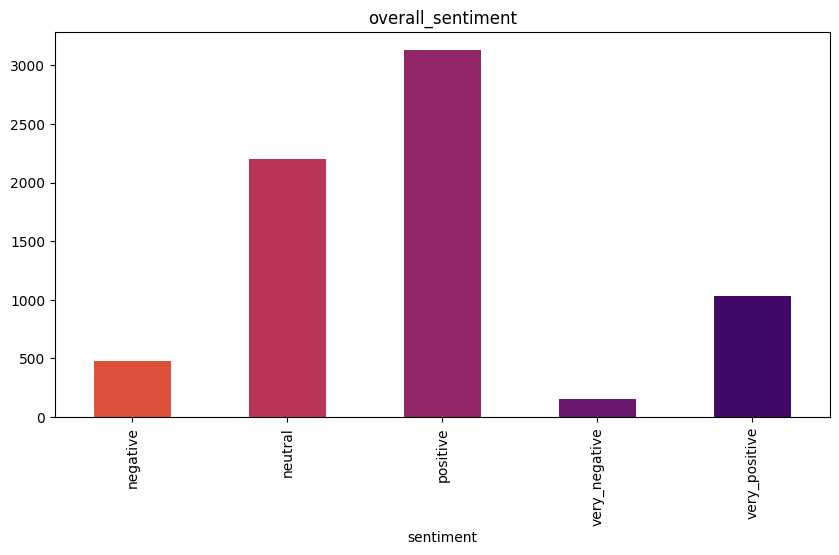

In [ ]:
ax = df2['overall_sentiment'].value_counts().sort_index().plot(kind="bar", title="overall_sentiment", color=color, figsize=(10, 5))
ax.set_xlabel('sentiment')
plt.show()

In [ ]:
df2['overall_sentiment'] = df2['overall_sentiment'].replace(['very_positive', 'positive',
                                                     'neutral', 'negative', 
                                                     'very_negative'], 
                                                    [1, 1, 0, -1, -1])


In [ ]:
df2.dropna(inplace=True)
df2.drop_duplicates(inplace=True)

In [ ]:
df2.head()

,text_corrected,overall_sentiment
0,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,1
1,The best of #10 YearChallenge! Completed in le...,1
2,Sam Thorne @Strippin ( Follow Follow Saw every...,1
3,10 Year Challenge - Sweet Dee Edition,1
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,0


In [ ]:
total = df2.groupby('overall_sentiment').count()['text_corrected'].reset_index().sort_values(by = 'text_corrected', ascending = False)
total.style.background_gradient()

,overall_sentiment,text_corrected
2,1,4133
1,0,2196
0,-1,630


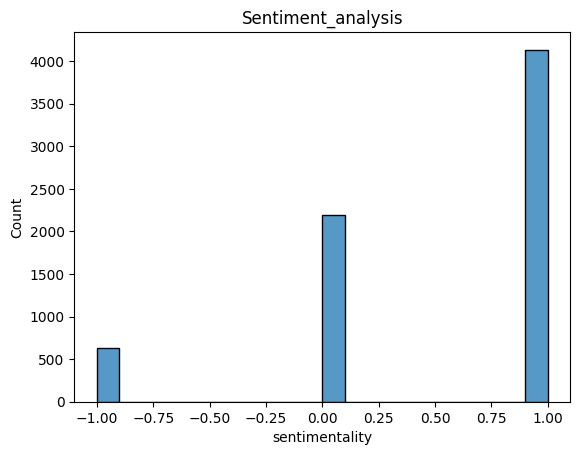

In [ ]:
sns.histplot(df2['overall_sentiment'], bins=20, kde=False)
plt.title('Sentiment_analysis')
plt.xlabel('sentimentality')
plt.show()

###Preprocessing

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions

def text_cleaning(text):
    text = str(text).lower()
    text = ' '.join([elem for elem in text.split(' ') if elem.isalpha()])
    text = re.sub(re.compile(r'https?://\S+|www\.\S+'), '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in (stopwords.words('english') + ['ha', 'wa']))
    return text

def update_text(text):
    new_words = []
    flag = False
    text = contractions.fix(text)
    words = text.split()
    lem = WordNetLemmatizer()
    for word in words:
        if flag:
            word = 'not_' + word
            flag = False
        if word in ['not', 'no', 'never', "n't"]:
            flag = True
        else:
            new_words.append(lem.lemmatize(word))
    return ' '.join(new_words)

In [ ]:
df2['text_corrected'] = df2['text_corrected'].apply(lambda x: text_cleaning(x))
df2['text_corrected'] = df2['text_corrected'].apply(lambda x: update_text(x))

df2['text_corrected'] = df2['text_corrected'].apply(lambda x: remove_stopwords(x))   

In [ ]:
df2.head()

,text_corrected,overall_sentiment
0,look friend lightyear sohalikut trend play yea...,1
1,best completed le kudu ji pm jan mumbai india,1
2,sam thorne follow follow saw everyone posting ...,1
3,year challenge sweet dee edition,1
4,year challenge not_filter hilarious year chall...,0


In [ ]:
df2['text_split'] = df2['text_corrected'].apply(lambda x: str(x).split()) 

In [ ]:
positive_words = df2[df2['overall_sentiment'] == 1]
top = Counter([el for elem in positive_words['text_split'] for el in elem])

df_positive = pd.DataFrame(top.most_common(10))
df_positive.columns = ['Common_words','Count']
df_positive.style.background_gradient()

,Common_words,Count
0,meme,430
1,like,346
2,bill,227
3,get,206
4,know,165
5,friend,162
6,one,154
7,make,149
8,say,139
9,want,130


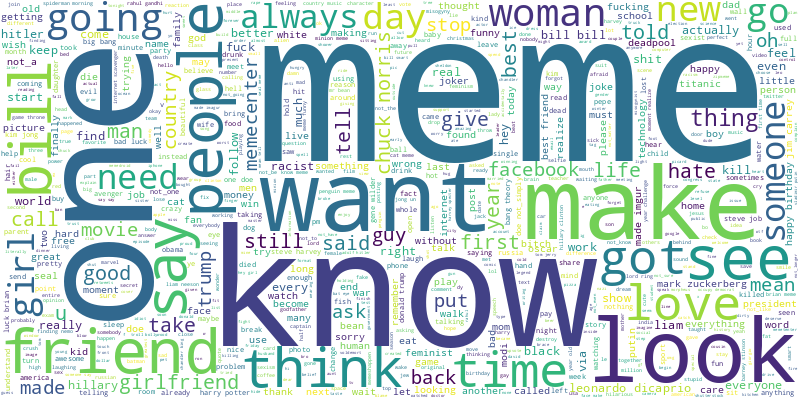

In [ ]:
all_texts = ','.join(list(df2['text_corrected'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, 
                      contour_color='steelblue', width=800, height=400)

wordcloud.generate(all_texts)
wordcloud.to_image()

In [ ]:
vectorizer = CountVectorizer(min_df=10)
count_data = vectorizer.fit_transform(df2['text_corrected'])

In [ ]:
def print_top_words(vectorizer, count_data, n):
    words = vectorizer.get_feature_names_out()
    total = np.zeros(len(words))
    for elem in count_data:
        total += elem.toarray()[0]

    word_freq = Counter(' '.join(df2['text_corrected']).split())
    common_words = word_freq.most_common(15)

    words = [w[0] for w in common_words]
    counts = [w[1] for w in common_words]

    x_pos = np.arange(len(words))

    plt.subplot(title = f'Most common {n} words')

    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation = 90, fontsize = 15) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

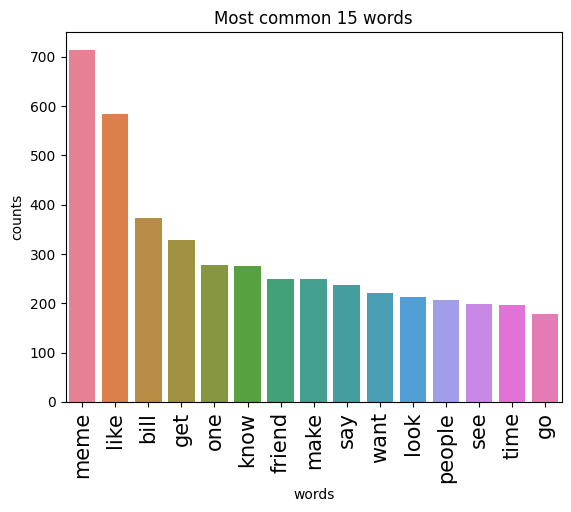

In [ ]:
print_top_words(vectorizer, count_data, 15)

###Baseline

<Axes: >

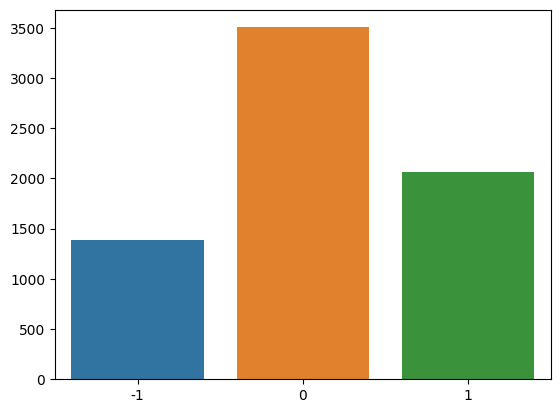

In [ ]:
def text_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    return 1 if sentiment > 0 else -1 if sentiment < 0 else 0

df2['possible_sentiment'] = df2['text_corrected'].apply(text_sentiment)
sentiment_counts = df2['possible_sentiment'].value_counts()

sns.barplot(x = sentiment_counts.index, y = sentiment_counts.values)

In [ ]:
sentiment_counts.values

array([3504, 2064, 1391])

In [ ]:
print((df2['overall_sentiment'] == df2['possible_sentiment']).mean())

0.35278057192125306


Actual results: 



*   Positive: 4133
*   Negative: 630
*   Neutral: 2196

----------
Baseline results:



*   Positive: 2064
*   Negative: 1391
*   Neutral: 3504




In [ ]:
pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def text_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    
    if compound_score > 0:
        return 1
    elif compound_score < 0:
        return -1
    else:
        return 0

df2['possible_sentiment2'] = df2['text_corrected'].apply(text_sentiment)
sentiment_counts2 = df2['possible_sentiment2'].value_counts()


<Axes: >

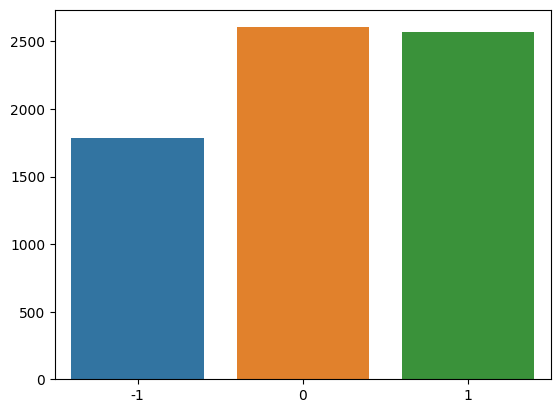

In [ ]:
sns.barplot(x = sentiment_counts2.index, y = sentiment_counts2.values)

In [ ]:
sentiment_counts2.values

array([2605, 2572, 1782])

In [ ]:
print((df2['overall_sentiment'] == df2['possible_sentiment2']).mean())

0.37950855007903433


### Model

##### model 1 with embedding matrix

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df2['text_corrected'].values)

X = tokenizer.texts_to_sequences(df2['text_corrected'].values)
X = pad_sequences(X, padding='post', maxlen=100)
y = to_categorical(df2['overall_sentiment'], num_classes=3)

num_words = len(tokenizer.word_index) + 1

glove_file = 'glove.6B.100d.txt'
embedding_dim = 100
num_words = 5000

def load_embeddings(file):
    embeddings_index = {}
    with open(file, 'r') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

def prepare_embedding_matrix(num_words, word_index, embeddings_index, embedding_dim):
    #embedding_matrix = np.zeros((num_words, embedding_dim))
    embedding_matrix = np.random.uniform(-0.5, 0.5, (num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None and len(embedding_vector) == embedding_dim:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embeddings_index = load_embeddings(glove_file)
embedding_matrix = prepare_embedding_matrix(num_words, tokenizer.word_index, 
                                            embeddings_index, embedding_dim)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=X.shape[1], input_shape=(None,),#))
                    weights=[embedding_matrix], trainable=True))
model.add(Dropout(0.5))
model.add(GRU(units=64, return_sequences=True, dropout=0.5, recurrent_dropout=0.2,
              kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(GRU(units=32, dropout=0.5, recurrent_dropout=0.2,
              kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(3, activation='softmax'))
    
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

early_stop = EarlyStopping(monitor='val_acc', patience=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33,
                                                    random_state=0)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, 
                    callbacks=[early_stop], validation_data=(X_test, y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         500000    
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 gru (GRU)                   (None, None, 64)          31872     
                                                                 
 batch_normalization (BatchN  (None, None, 64)         256       
 ormalization)                                                   
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                        

146/146 [==============================] - 57s 336ms/step - loss: 1.1556 - accuracy: 0.5287 - val_loss: 1.0758 - val_accuracy: 0.5938
Epoch 2/10
146/146 [==============================] - ETA: 0s - loss: 1.0377 - accuracy: 0.5858

146/146 [==============================] - 45s 307ms/step - loss: 1.0377 - accuracy: 0.5858 - val_loss: 1.0364 - val_accuracy: 0.5938
Epoch 3/10
146/146 [==============================] - ETA: 0s - loss: 1.0090 - accuracy: 0.5918

146/146 [==============================] - 48s 331ms/step - loss: 1.0090 - accuracy: 0.5918 - val_loss: 0.9891 - val_accuracy: 0.5938
Epoch 4/10
146/146 [==============================] - ETA: 0s - loss: 0.9872 - accuracy: 0.5922

146/146 [==============================] - 45s 312ms/step - loss: 0.9872 - accuracy: 0.5922 - val_loss: 0.9736 - val_accuracy: 0.5938
Epoch 5/10
146/146 [==============================] - ETA: 0s - loss: 0.9726 - accuracy: 0.5942

146/146 [==============================] - 48s 326ms/step - loss: 0.9726 - accuracy: 0.5942 - val_loss: 0.9600 - val_accuracy: 0.5938
Epoch 6/10
146/146 [==============================] - ETA: 0s - loss: 0.9593 - accuracy: 0.5944

146/146 [==============================] - 48s 327ms/step - loss: 0.9593 - accuracy: 0.5944 - val_loss: 0.9513 - val_accuracy: 0.5938
Epoch 7/10
146/146 [==============================] - ETA: 0s - loss: 0.9468 - accuracy: 0.5940

146/146 [==============================] - 44s 299ms/step - loss: 0.9468 - accuracy: 0.5940 - val_loss: 0.9420 - val_accuracy: 0.5938
Epoch 8/10
146/146 [==============================] - ETA: 0s - loss: 0.9402 - accuracy: 0.5937

146/146 [==============================] - 52s 358ms/step - loss: 0.9402 - accuracy: 0.5937 - val_loss: 0.9346 - val_accuracy: 0.5938
Epoch 9/10
146/146 [==============================] - ETA: 0s - loss: 0.9330 - accuracy: 0.5940

146/146 [==============================] - 45s 309ms/step - loss: 0.9330 - accuracy: 0.5940 - val_loss: 0.9300 - val_accuracy: 0.5938
Epoch 10/10
146/146 [==============================] - ETA: 0s - loss: 0.9303 - accuracy: 0.5940

146/146 [==============================] - 44s 300ms/step - loss: 0.9303 - accuracy: 0.5940 - val_loss: 0.9235 - val_accuracy: 0.5938


In [ ]:
print("Training Loss: {:.4f}".format(history.history['loss'][-1]))
print("Training Accuracy: {:.4f}".format(history.history['accuracy'][-1]))
print("Validation Loss: {:.4f}".format(history.history['val_loss'][-1]))
print("Validation Accuracy: {:.4f}".format(history.history['val_accuracy'][-1]))

Training Loss: 0.9303
Training Accuracy: 0.5940
Validation Loss: 0.9235
Validation Accuracy: 0.5938


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

72/72 [==============================] - 2s 31ms/step - loss: 0.9235 - accuracy: 0.5938


In [ ]:
print('Test score', score[0])
print('Test accuracy', score[1])

Test score 0.9234805703163147
Test accuracy 0.5938180088996887


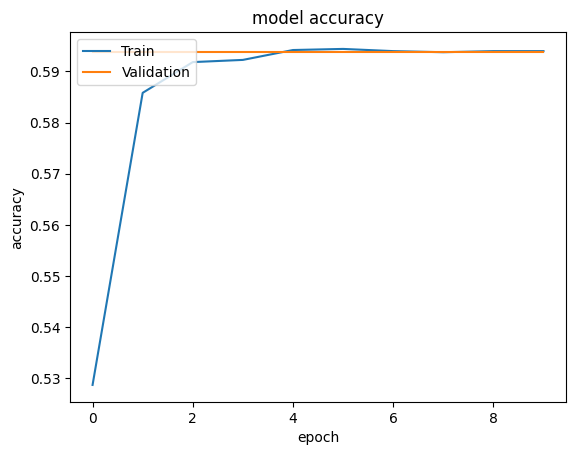

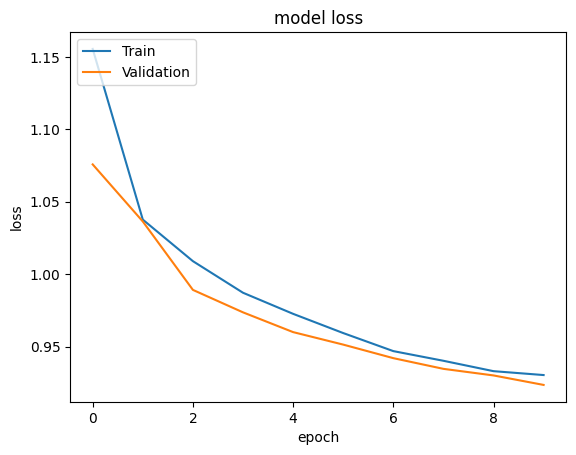

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save('model_v1')

In [ ]:
#from keras.models import load_model
model = load_model('model_v1')

### Check



*   status
*   totalResults
*   articles
*   author
*   title
*   description
*   url
*   urlToImage
*   publishedAt
*   content
*   source





In [ ]:
url = 'https://newsapi.org/v2/everything'
api_key = '7d38c0b6f42d4b6aad377e3cc9f15181'

params = {
    'q': 'news',
    'language': 'en',
    'sortBy': 'publishedAt',
    'apiKey': api_key
}

response = requests.get(url, params = params)

if response.status_code == 200:
    print('Successful!')
else:
    print('Failed!')

Successful!


In [ ]:
data = response.json()

In [ ]:
import csv

In [ ]:
data_list = []
for elem in data['articles']:
    data_list.append({
        'content': elem['content']
    })

with open('new_data.csv', 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['content'])
    writer.writeheader()
    for record in data_list:
        writer.writerow(record)

In [ ]:
new_df = pd.read_csv('new_data.csv')
new_df.head()

,content
0,We use cookies and data to<ul><li>Deliver and ...
1,The board of directors of PotlatchDeltic Corpo...
2,"NEW YORK, May 04, 2023 (GLOBE NEWSWIRE) -- Gai..."
3,"Here we are, the 40th installment in the Linco..."
4,Designated News ReleaseFIRST QUARTER FINANCIAL...


In [ ]:
new_df.dropna(inplace=True)

In [ ]:
new_df['content'] = new_df['content'].apply(lambda x: text_cleaning(x))
new_df['content'] = new_df['content'].apply(lambda x: update_text(x)) 

new_df['content'] = new_df['content'].apply(lambda x: remove_stopwords(x))

new_df.head()

,content
0,use cooky data maintain google outage protect ...
1,board director potlatchdeltic corporation decl...
2,new may gainey mckenna egleston announces secu...
3,installment lincoln mark series debut exciting...
4,designated news releasefirst quarter financial...


In [ ]:
new_df.shape

(100, 1)